# Overview of Univariate Time Series

A univariate time series is a sequence of measurements of the same variable collected over time.  Most often, the measurements are made at regular time intervals.

One difference from standard linear regression is that the data are not necessarily independent and not necessarily identically distributed.  One defining characteristic of time series is that this is a list of observations where the ordering matters. Changing the order could change the meaning of the data.

# Time Series Considerations

* Is there a trend, meaning that, on average, the measurements tend to increase (or decrease) over time?
* Is there seasonality, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?
* Are their outliers? In regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.
* Is there a long-run cycle or period unrelated to seasonality factors?
* Is there constant variance over time, or is the variance non-constant?
* Are there any abrupt changes to either the level of the series or the variance?

<img src="http://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/_images/image8.png" />

# ARIMA Models

ARIMA (Autoregressive Integrated Moving Average) models relate the present value of a series to past values and past prediction errors.

Let $y_t$ be the observed value at time $t$. Then the simplest ARIMA model is:

$$\begin{equation}
y_t = \beta_1 y_{t-1} + \beta_0 + \epsilon
\end{equation}$$

Here $\beta_0$ and $\beta_1$ are the coefficients of OLS regression and $\epsilon$ is the residual.

This model is also called AR(1) since the value at time $t$ is only related to value at time $t-1$. 

In an AR(2) model, $y_t$ depends on both $y_{t-1}$ and $y_{t-2}$. 

$$\begin{equation}
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \beta_0 + \epsilon
\end{equation}$$

This can be extended to $AR(k)$ for any $k$, with the caveat that the value of $k$ must make sense in the context. $k$ is called the order of the model.

**Assumptions in AR Models**

* $\epsilon ∼ iid \space N(0,σ^2)$, meaning that the errors are independently distributed with a normal distribution that has mean 0 and constant variance.
* Properties of the error $\epsilon$ are independent of $y$.

# AutoCorrelation and Partial Autocorrelation

The  autocorrelation function (ACF) of a time series is the correlation between values of the series at different times, as a function of the two times or of the time lag.

$$\begin{equation}
ACF(k) = Corr(Y_t, Y_{t-k})
\end{equation}$$

The ACF is a way to measure the linear relationship between an observation at time $t$ and the observations at previous times. If we assume an $AR(k)$ model, then we may wish to only measure the association between $y_t$ and $y_{t−k}$ and filter out the linear influence of the random variables that lie in between (i.e., $y_{t−1},y_{t−2}, \dots, y_{t−k+1})$, which requires a transformation on the time series. Then by calculating the correlation of the transformed time series we obtain the partial autocorrelation function (PACF).

# Illustration using Google Stock Data

In [1]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
g_prices = pd.read_csv('google.csv', parse_dates=True, index_col=0, squeeze=True)

In [3]:
g_prices.head()

date
2005-02-07    196.03
2005-02-08    198.64
2005-02-09    191.58
2005-02-10    187.98
2005-02-11    187.40
Name: price, dtype: float64

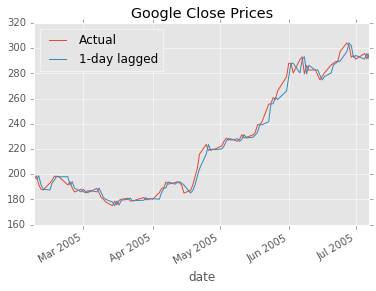

In [4]:
# Plot close prices and lagged prices
ax = g_prices.plot(title='Google Close Prices')
lagged_prices = g_prices.shift(1)
lagged_prices.plot(ax=ax)
pylab.legend(['Actual', '1-day lagged'], loc='upper left')

In [5]:
lagged_prices.head()

date
2005-02-07       NaN
2005-02-08    196.03
2005-02-09    198.64
2005-02-10    191.58
2005-02-11    187.98
Name: price, dtype: float64

In [6]:
# calculate autocorrelation between close prices and 1-day lagged values.
np.corrcoef(g_prices[1:], lagged_prices[1:])

array([[ 1.        ,  0.99467534],
       [ 0.99467534,  1.        ]])

In [7]:
# Easier way
g_prices.autocorr(1)

0.99467534499911059

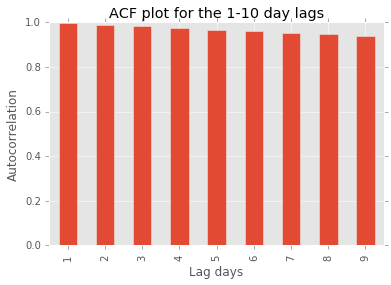

In [8]:
# ACF Plot

autocorrs = [g_prices.autocorr(i) for i in range(1, 10)]
ax = pd.Series(autocorrs, index=range(1, 10)).plot(kind='bar', title='ACF plot for the 1-10 day lags')
ax.set(xlabel='Lag days', ylabel='Autocorrelation')

d:\Anaconda3\envs\latest\lib\site-packages\statsmodels\regression\linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


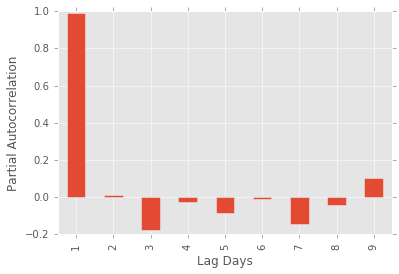

In [9]:
from statsmodels.tsa.stattools import pacf

google_pacf = pacf(g_prices)[1:10]
ax = pd.Series(index=range(1, 10), data=google_pacf).plot(kind='bar')
ax.set(xlabel='Lag Days', ylabel='Partial Autocorrelation')

In [10]:
data_df = pd.concat({'actual': g_prices[1:], 'lagged': lagged_prices[1:]}, axis=1)

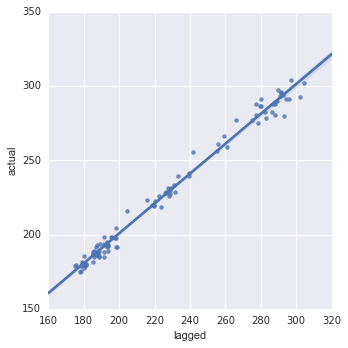

In [11]:
# plot the regression model. At first glance, it looks like a good fit.
# Note that that in line with the AR(1) model, the lagged values go on x, and the actual values go on y.

import seaborn as sns
sns.lmplot('lagged', 'actual', data=data_df)

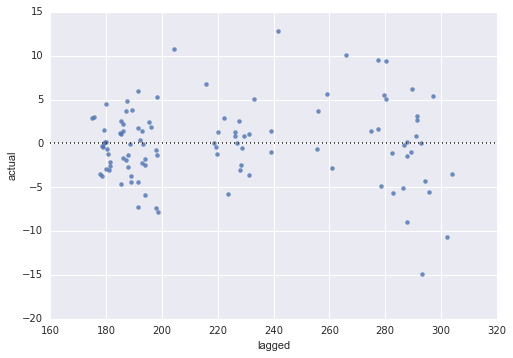

In [12]:
# What do the residuals look like?
sns.residplot('lagged', 'actual', data=data_df)

In [13]:
import statsmodels.formula.api as sm

model = sm.ols('actual ~ lagged', data=data_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9502.
Date:                Mon, 01 May 2017   Prob (F-statistic):          1.71e-102
Time:                        23:55:55   Log-Likelihood:                -302.11
No. Observations:                 104   AIC:                             608.2
Df Residuals:                     102   BIC:                             613.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3585      2.353     -0.152      0.879      -5.025       4.308
lagged         1.0059      0.010     97.476      0.000       0.985       1.026
==============================================================================
Omnibus:                        4.453   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.837
Skew:                          -0.003   Prob(JB):                       0.0540
Kurtosis:                       4.161   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

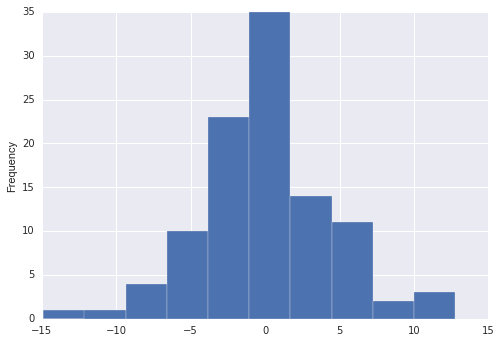

In [14]:
result.resid.plot(kind='hist')

# Time-series Cross Validation

* Fit the model to the data ${y_1, y_2, \dots, y_t}$ where $t$ is the minimum number of observations to include in the model. 
* Use the above model to estimate $y_{t+1}$.
* Calculate the error of the estimate, $\hat{y_{t+1}} - y_{t+1}$.
* Repeat for ${y_{t+2}, y_{t+3}, \dots, y_{t+n-1}}$, where $n$ is the total number of observations.

For more details, see http://robjhyndman.com/hyndsight/crossvalidation/.

In [15]:
def time_series_cv(data, x, y, min_periods):
    """
    Return the squared error from the cross validation of the regression model 'y ~ x' over `data_df`.
    """
    assert min_periods > 0
    assert len(data) > min_periods
    
    formula = ' ~ '.join([y, x])
    
    # Series to return the results. This will only contain min_periods:end subset of the dates in data.
    results = pd.Series(index=data.index[min_periods:], data=np.nan, name='squared_error')
    
    for i in range(min_periods, len(data)):
        # Build the model using the first i observations (0, 1, ..., i-1)
        fit_df = data.iloc[:i]
        fit_result = sm.ols(formula=formula, data=fit_df).fit()
        
        # Predict using the i-th observation
        test_df = data.iloc[i:i+1]
        predicted = fit_result.predict(test_df)
        
        # Calculcate and save squared error
        squared_error = (predicted.values - test_df[y].values) ** 2.0
        results[test_df.index[0]] = squared_error

    return results


In [16]:
cv_results = time_series_cv(data_df, x='lagged', y='actual', min_periods=30)

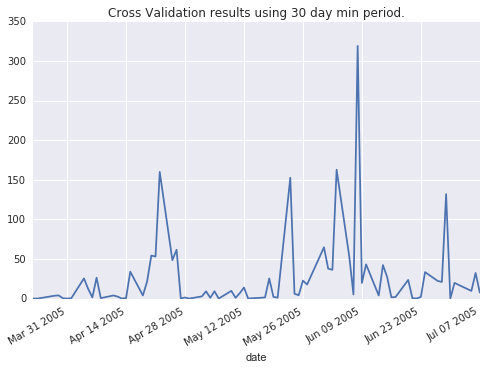

In [17]:
cv_results.plot(title='Cross Validation results using 30 day min period.')